In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print(cv2.__version__)
print(tf.__version__)

3.4.1
1.8.0


# Load high resolution image

(200, 320)
320
200


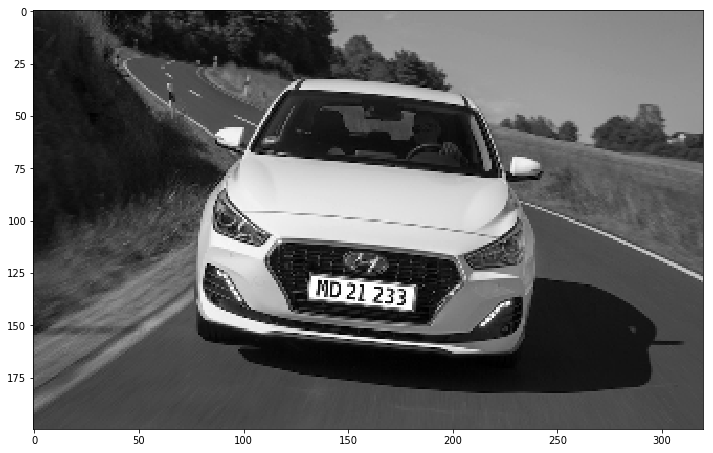

In [47]:
filename = 'nummerplade.png'
img_highres = cv2.imread(filename)
img_highres = cv2.cvtColor(img_highres, cv2.COLOR_BGR2GRAY)
img_highres = img_highres.astype(np.float32) / 255.
img_highres = cv2.resize(img_highres,(320,200))
#img_highres = img_highres[80:200,360:560]
print(img_highres.shape)
plt.figure(figsize=(12,12))
plt.imshow(img_highres,cmap='gray')
print(int(320/4)*4)
print(int(200/4)*4)

# Test low resolution image

(100, 160)


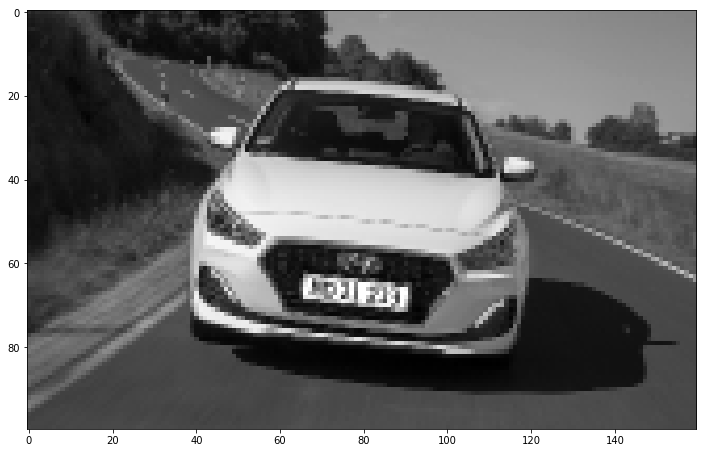

In [48]:
scale = 2.
img_lowres = cv2.resize(img_highres,None,fx=1/scale, fy=1/scale)
print(img_lowres.shape)
plt.figure(figsize=(12,12))
plt.imshow(img_lowres,cmap='gray')

# Generate series of low resolution images with random motion (translation)

(0.0, 0.0)


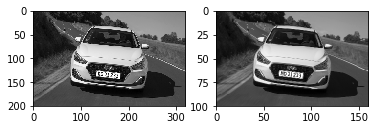

(0.36842105, 0.36842105)


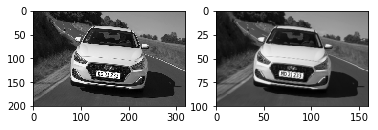

(0.7368421, 0.7368421)


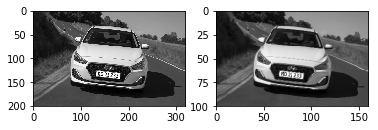

(1.1052631, 1.1052631)


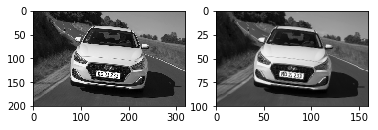

(1.4736842, 1.4736842)


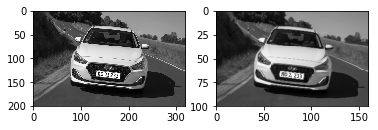

(1.8421053, 1.8421053)


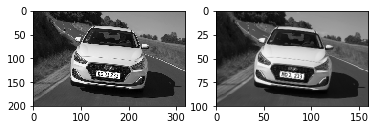

(2.2105262, 2.2105262)


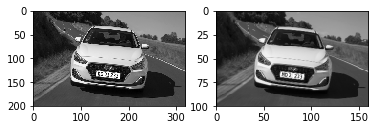

(2.5789473, 2.5789473)


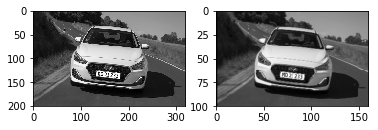

(2.9473684, 2.9473684)


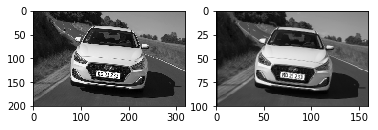

(3.3157895, 3.3157895)


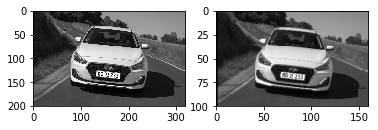

(3.6842105, 3.6842105)


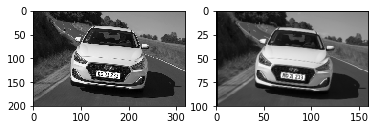

(4.0526314, 4.0526314)


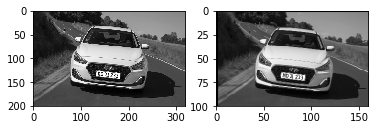

(4.4210525, 4.4210525)


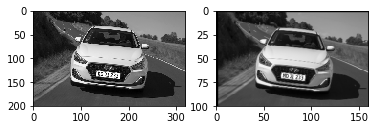

(4.7894735, 4.7894735)


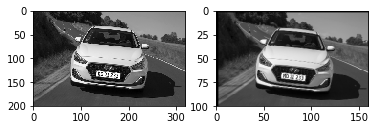

(5.1578946, 5.1578946)


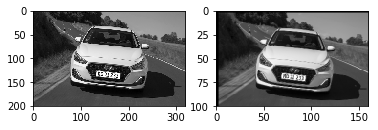

(5.5263157, 5.5263157)


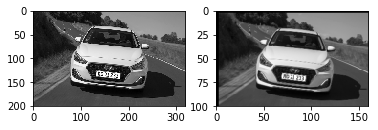

(5.894737, 5.894737)


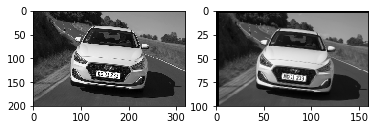

(6.263158, 6.263158)


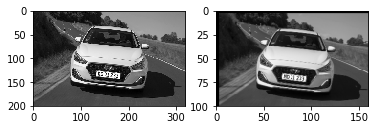

(6.631579, 6.631579)


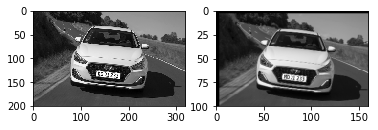

(7.0, 7.0)


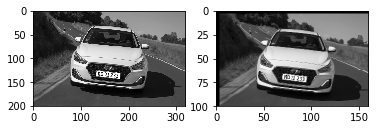

In [49]:
# Number of frames to generate
no_frames = 20;

# Where images and optical flow (motion) will be stored
images = []
flowX = []
flowY = []

# Set up resampling grid
N = img_highres.shape[0]
M = img_highres.shape[1]
x = np.arange(M)
y = np.arange(N)
X, Y = np.meshgrid(x, y)
X = X.astype(np.float32)
Y = Y.astype(np.float32)

# Generate image series
dx = np.linspace(0,7, no_frames)
for frame in range(0, no_frames):
    
    # Random translation
    U = np.ones((N,M), dtype=np.float32) * dx[frame]#np.ones((N,M), dtype=np.float32) * np.random.randn(1).astype(np.float32) * 8
    V = np.ones((N,M), dtype=np.float32) * dx[frame]#np.ones((N,M), dtype=np.float32) * np.random.randn(1).astype(np.float32) * 8
    
    # Apply motion
    X2 = X - U;
    Y2 = Y - V;
    img = cv2.remap(img_highres, X2, Y2, cv2.INTER_LINEAR)
    
    # Downsample
    img = cv2.resize(img,None,fx=1/scale, fy=1/scale)
    
    # Store
    images.append(img)
    flowX.append(U)
    flowY.append(V)
    print((U[0,0],V[0,0]))
    
    
    # Display
    plt.figure()
    plt.subplot(121); plt.imshow(img_highres, cmap='gray')
    plt.subplot(122); plt.imshow(images[frame], cmap='gray')
    plt.show()

In [50]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

/home/vclab/anaconda3/envs/henrik/lib/python3.6/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


# Test warp and downsampling in TF

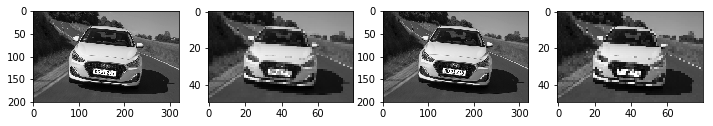

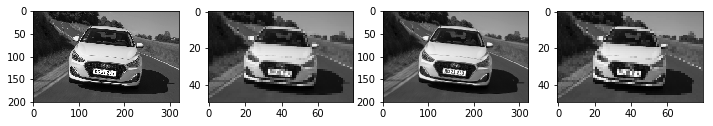

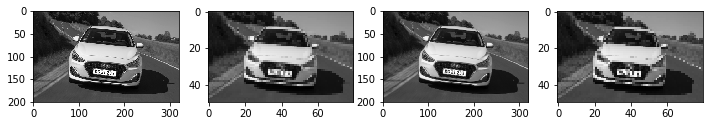

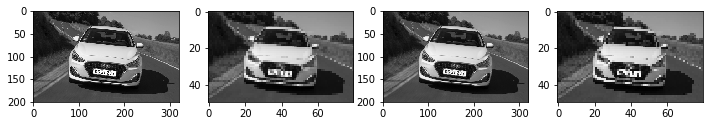

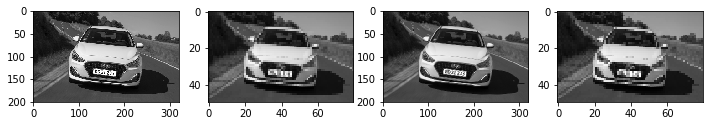

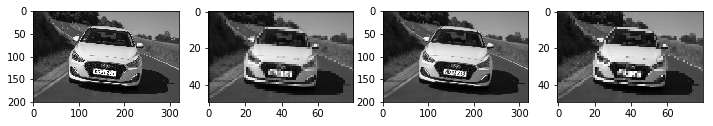

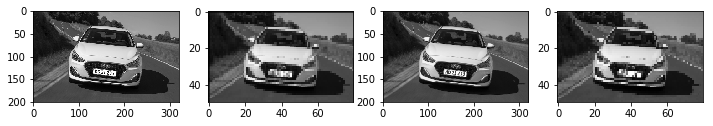

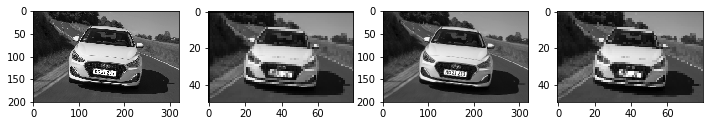

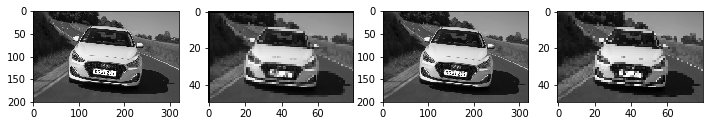

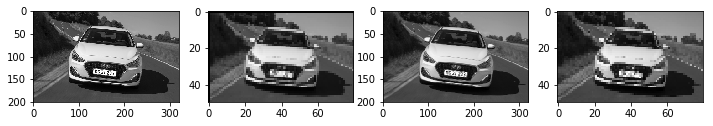

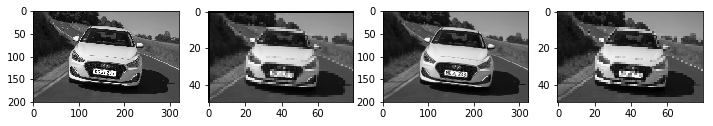

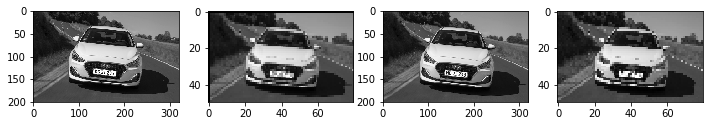

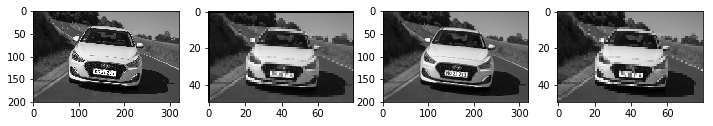

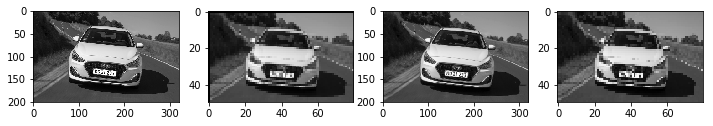

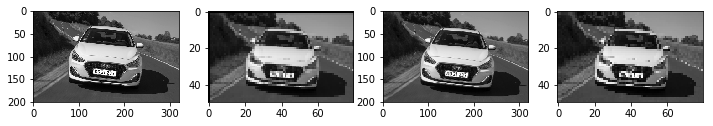

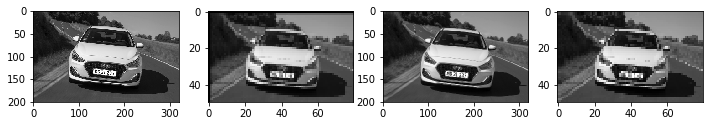

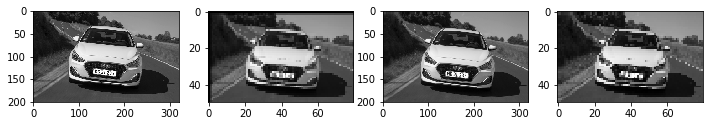

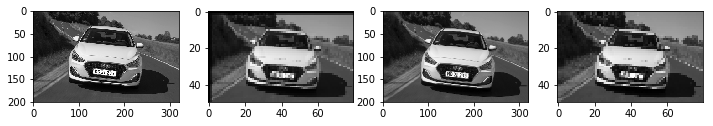

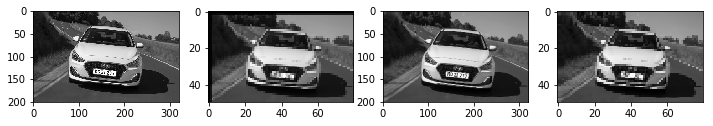

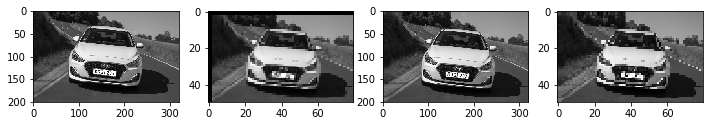

In [31]:
def warp_and_downscale():
    img_highres = tf.placeholder(tf.float32,shape=((1,N,M,1)),name='img')
    flow = tf.placeholder(tf.float32,shape=((1,N,M,2)),name='flow')
    img_warped = tf.contrib.image.dense_image_warp(img_highres,flow)
    img_lowres = tf.image.resize_bilinear(img_warped,[int(N/scale),int(M/scale)])
    return {
        'img_highres': img_highres,
        'flow': flow,
        'img_warped': img_warped,
        'img_lowres': img_lowres
    }

was = warp_and_downscale()

# Reshape high res image
img_highres_np = np.reshape(img_highres,(1,N,M,1)).astype(np.float32)

for frame in range(0, no_frames):
    flow_np = np.zeros((1,N,M,2), dtype=np.float32)
    flow_np[0,:,:,0] = flowY[frame]-1
    flow_np[0,:,:,1] = flowX[frame]-1
    feed_dict = {
        was['img_highres']: img_highres_np,
        was['flow']: flow_np
    }
    img_lowres_out, img_warped_out = sess.run([was['img_lowres'],was['img_warped']], feed_dict=feed_dict)
    img_warped_out = img_warped_out.squeeze()
    img_lowres_out = img_lowres_out.squeeze()
    
    plt.figure(figsize=(12, 12))
    plt.subplot(141)
    plt.imshow(img_highres, cmap='gray')
    plt.subplot(142)
    plt.imshow(images[frame], cmap='gray')
    plt.subplot(143)
    plt.imshow(img_warped_out, cmap='gray')
    plt.subplot(144)
    plt.imshow(img_lowres_out, cmap='gray')
    

# Set up cost function and initialize tensors

In [51]:
# Optimization
learning_rate = 0.01
global_step_encoder = tf.Variable(0, trainable=False)
starter_learning_rate = learning_rate
learning_rate_encoder = tf.train.exponential_decay(starter_learning_rate, global_step_encoder, 100, 0.9, staircase=True)
tv_weight = 0.0001

# Cost function - essentially the same as function warp_and_downscale()
img_highres_tf = tf.Variable(np.random.uniform(size=(1,N,M,1)), name = "img_highres")
img_highres_tile = tf.tile(img_highres_tf,[no_frames,1,1,1])
ref_tf = tf.placeholder(tf.float32,shape=((no_frames,int(N/scale),int(M/scale),1)),name='img')
flow_tf = tf.placeholder(tf.float32,shape=((no_frames,N,M,2)),name='flow')
img_warped_tf = tf.contrib.image.dense_image_warp(img_highres_tile,flow_tf)
img_warped_tf = tf.image.resize_bilinear(img_warped_tf,[int(N/scale),int(M/scale)])
mse = tf.losses.mean_squared_error(img_warped_tf,ref_tf)
tv = tf.image.total_variation(img_highres_tf) / N / M
cost = mse + tv_weight * tf.cast(tv, tf.float32)

# Optimizer
optimizer_encoder = tf.train.AdamOptimizer(learning_rate = learning_rate)
train_op_encoder = optimizer_encoder.minimize(loss=cost,global_step=global_step_encoder)

# Initialize
sess.run(tf.global_variables_initializer())
ref_np = np.zeros((no_frames,int(N/scale),int(M/scale),1), dtype=np.float32)
flow_np = np.zeros((no_frames,N,M,2), dtype=np.float32)
for frame in range(0, no_frames):    
    ref_np[frame,:,:,0] = images[frame]
    flow_np[frame,:,:,0] = flowY[frame]-1
    flow_np[frame,:,:,1] = flowX[frame]-1

feed_dict = {
        ref_tf: ref_np,
        flow_tf: flow_np
}

# Test loss
loss_val, tv_val = sess.run([cost,tv], feed_dict=feed_dict)
print((loss_val, tv_val))

(array([0.12761872], dtype=float32), array([0.66674847]))


# Train model

Global step 1001, 0.003487, loss=9.578597e-05


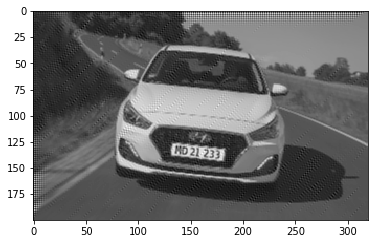

Global step 1101, 0.003138, loss=9.494845e-05


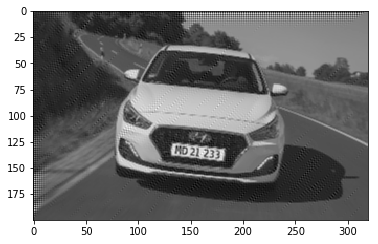

Global step 1201, 0.002824, loss=9.431381e-05


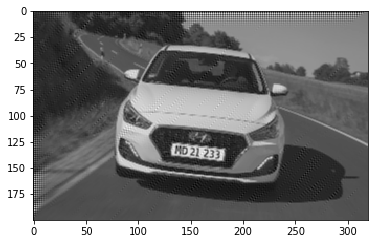

Global step 1301, 0.002542, loss=9.383177e-05


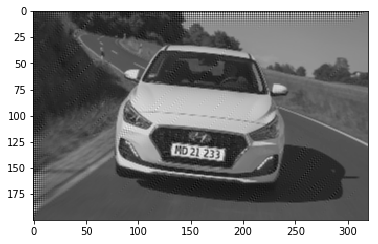

Global step 1401, 0.002288, loss=9.346627e-05


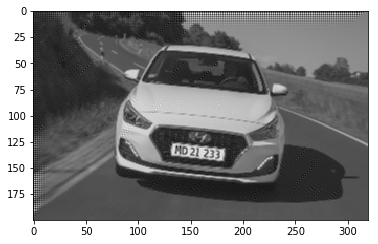

Global step 1501, 0.002059, loss=9.319841e-05


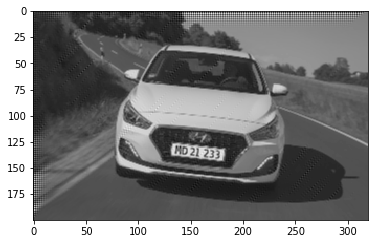

Global step 1601, 0.001853, loss=9.301190e-05


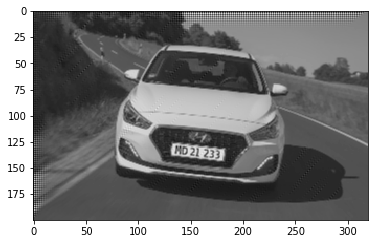

Global step 1701, 0.001668, loss=9.288465e-05


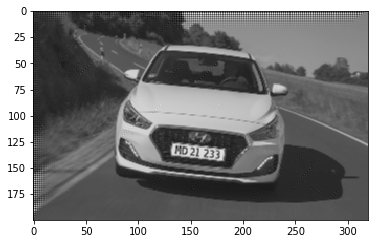

Global step 1801, 0.001501, loss=9.279943e-05


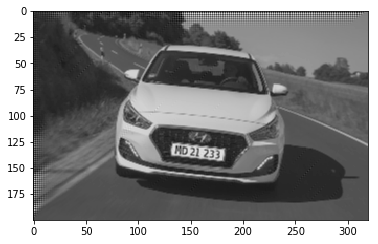

Global step 1901, 0.001351, loss=9.274630e-05


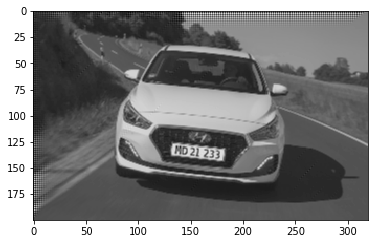

In [53]:
for iter in range(1000):
    lr,_,loss_val = sess.run([learning_rate_encoder,train_op_encoder,cost], feed_dict=feed_dict)
    gs = tf.train.global_step(sess, global_step_encoder)
    if iter%100 == 0:
        out = sess.run(img_highres_tf)
        out = out.squeeze()
        plt.figure()
        plt.imshow(out, cmap='gray')
        print("Global step %i, %f, %s=%e" % (gs, lr, 'loss',loss_val))
        plt.show()

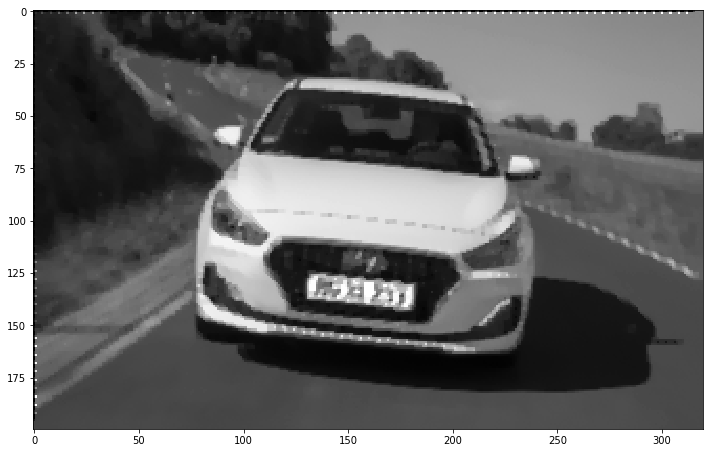

In [34]:
plt.figure(figsize=(12,12))
plt.imshow(out,cmap='gray',vmin=0,vmax=1)

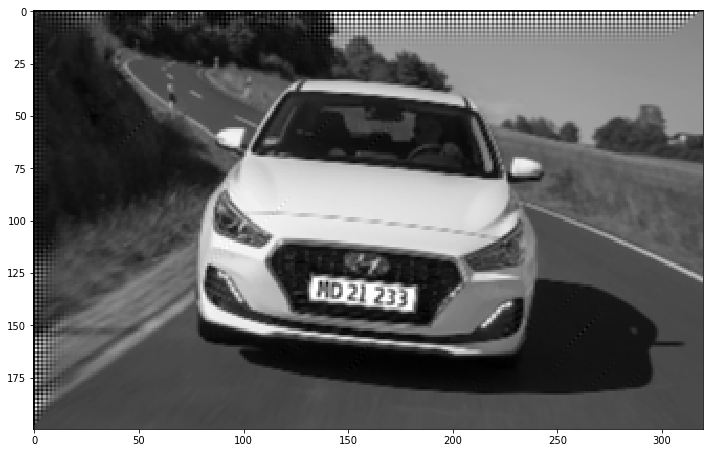

In [54]:
plt.figure(figsize=(12,12))
plt.imshow(out,cmap='gray',vmin=0,vmax=1)